### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [35]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

If the InDelScanner directory is not on your path, modify the `indels_path` variable to point to it.

In [4]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

Specify the working directory: this should be where your input files are located.

In [5]:
os.chdir("/mnt/c/Users/Maya/VMShare/mek_results")

## Experiment design
In this experiment, the peptide libraries were split by FACS into three gates: high, medium and low. This DNA was isolated by PCR and sequenced in the same Illumina run. Due to initial low covereage of the "low" gate, this fraction was re-sequenced to yield "low-v2". The next cell loads the alignment dictionaries from both sequencing runs and combines into one Counter class.
Because of re-sequencing in the low fraction, we choose to combine the counts from both sequencing runs to take advantage of the total higher coverage.

### Library composition
The peptide libraries were randomized in the form MPKKKXTPXQXNXAPDGS; the randomized X positions are 6, 9, 11 and 13. Additionally, there is a possible insertion of A at position 7a (after TP) and a potential randomized X insertion at postion 8a. X may be any one of ADFGIKLMPVWY.

In [6]:
with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

Start inspection of the dataset by looking for most enriched variants in each gate and checking their presence in the other gates. This treats the NGS dataset as a way to find the most active variants in a straighforward way - the most active variants should:
* have a strong enrichment for the top gate, with high counts in 'high' gate and low to zero counts in the 'low' gate; though there will be some bleed-over of signal due to errors during FACS
* be highly present in the 'high' gate

Output files: Top hits - FRACTION NAME.csv

In [31]:
def top_variant_distribution(mek, fraction, filename):

    top = mek[fraction].most_common(200)
    with open(filename, 'w') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(['Mutation', 'High', 'Medium', 'Low'])
        for pair in top:
            protein = pair[0]
            csv_writer.writerow([protein, mek['high'][protein], mek['med'][protein], mek['low-t'][protein]] )

top_variant_distribution(mek, 'high', 'Top hits - High.csv')
top_variant_distribution(mek, 'med', 'Top hits - Med.csv')
top_variant_distribution(mek, 'low-t', 'Top hits - Low.csv')

df_top = pd.read_csv('Top hits - High.csv')
df_top.head(15)

,Mutation,High,Medium,Low
0,6L/7aI/8aA/9L/11F/13M,1185,33,6
1,6F/7aP/9W/11L/13M,903,81,15
2,6L/7aF/9L/11I/13I,899,2,8
3,6A/7aI/8aA/9L/11L/13I,893,3,19
4,6W/7aI/9F/11L/13V,880,34,20
5,6A/7aP/8aA/9L/11V/13W,872,0,18
6,6L/7aI/8aA/9M/11W/13W,871,24,18
7,6V/7aP/8aA/9F/11F/13M,869,1,5
8,6A/7aK/9L/11L/13W,859,0,14
9,6A/7aI/8aA/9L/11V/13M,852,0,26


### Single position enrichments
The original protein before sorting is balanced: each randomized position contains an equal amount of each amino acid, as far as technically possible.

If a particular amino acid (for example, L in position 9) is adaptive for strong binding, the 'high' gate of the library should be enriched for that amino acid in that position. Hence, a deviation from balanced composition at any one position indicates that the enriched amino acids promote active binding while those depleted (and correspondingly enriched in the 'low' gate) are disruptive to binding.

In [137]:
def passes_restriction(m_by_pos, restrict):
    """
    Helper function in case we are looking at enrichment with certain positions fixed. 'restrict' is a dictionary of the form
    restrict[position] = ['A', 'L'] etc.
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    if restrict:
        for position, allowed_aa in restrict.items():
            try:
                aa = m_by_pos[position]
            except KeyError:
                aa = wt[position]
            
            if aa not in allowed_aa:
                return False
    return True


def single_fraction_enrichment(mek, fraction, cutoff, restrict = False):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    point_distribution = {pos: {aa: 0 for aa in valid_aa} for pos in ['6', '7a', '8a', '9', '11', '13']}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

    # the input data is formatted as mek['fraction'][mutation_string] = integer
    # each mutation is a collection of mutations of the format Integer + single letterAA code, separated by '/'
    # we are querying this by position, so need to split by position and convert into a new Counter:
    # mek['fraction']['position']['amino_acid'] = integer
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            mutation_list = mutation_string.split('/')
            # each position is now PositionLetter; the last character is the amino acid
            # get observed AAs and check they're valid
            # m_by_pos[position] = AA
            
            for point_mutation in mutation_list:
                pos = point_mutation[:-1]
                aa = point_mutation[-1]
            m_by_pos = {point_mutation[:-1] : point_mutation[-1] for point_mutation in mutation_list }
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            for pos in wt.keys():  # need to do it this way so that WT positions are included
                try:
                    aa = m_by_pos[pos]
                except KeyError:
                    aa = wt[pos]
                point_distribution[pos][aa] += count
    
    return point_distribution

In [98]:
def make_composition_plot_per_position(df_point, title_text):
    sns.set_palette("tab20", 13)
    cols = df_point.columns.values.tolist()  
    aa_all = df_point.index.values.tolist()  # have the same labels and colorscheme for all charts

    fig = plt.figure(figsize=(13,2.5))
    fig.suptitle(title_text)

    axes = list(range(len(cols)))  # make axes with a column for each position

    for i in range(len(cols)):
        axes[i] = fig.add_subplot(1, len(cols), i + 1)
        plt.pie(df_point[cols[i]], startangle=90)
        axes[i].set_title(cols[i])

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in sns.color_palette("tab20")]
    fig.legend(markers, aa_all, numpoints=1, loc='center left', ncol=2)

    plt.show()

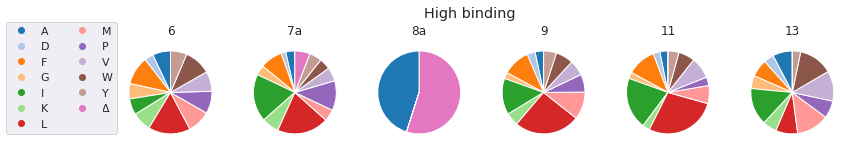

In [125]:
# Now use the distribution in this fraction to make plots
high = single_fraction_enrichment(mek, 'high', 10)
df_point_high = pd.DataFrame.from_dict(high)
make_composition_plot_per_position(df_point_high, 'High binding')

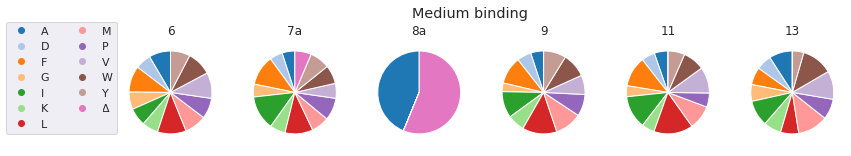

In [100]:
med = single_fraction_enrichment(mek, 'med', 3)
df_point = pd.DataFrame.from_dict(med)
make_composition_plot_per_position(df_point, 'Medium binding')

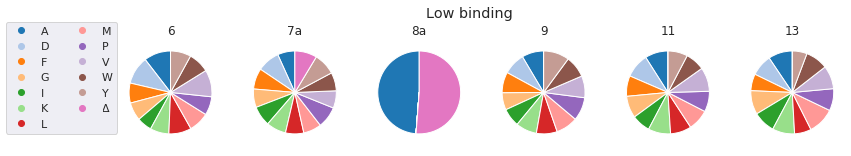

In [101]:
low = single_fraction_enrichment(mek, 'low-t', 3)
df_point = pd.DataFrame.from_dict(low)
make_composition_plot_per_position(df_point, 'Low binding')

### Relative enrichment at other positions when some have a specific amino acid

When position 9=L, and 11=L, what are the single site preferences at the 
other positions (6, 7.5, 8.5 and 13)

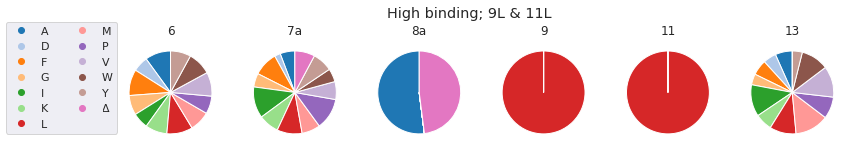

In [130]:
restrict = {'9':['L'], '11':['L']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L')

When position 9=I, and 11=L, what are the single site preferences at the 
other positions (6, 7.5, 8.5 and 13)

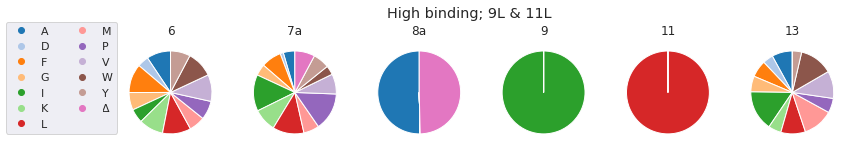

In [131]:
restrict = {'9':['I'], '11':['L']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L')

When position 9=L, and 11=I, what are the single site preferences at the 
other positions (6, 7.5, 8.5 and 13)

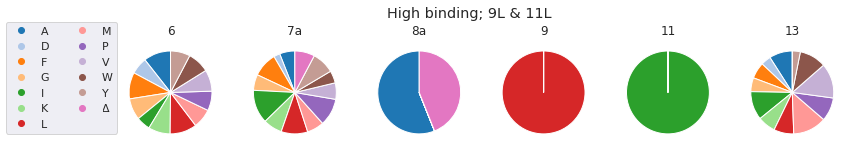

In [132]:
restrict = {'9':['L'], '11':['I']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L')

When position 7.5=insertion (any), and 8a=A, what are the single site 
preferences at position 9 and 11

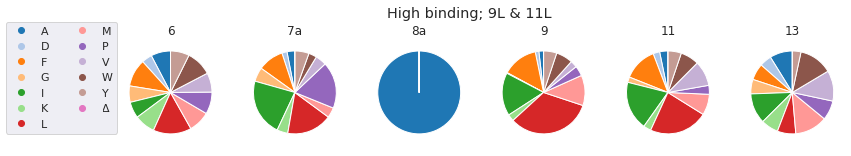

In [135]:
restrict = {'7a':['A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y'], '8a':['A']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L')

When position 7.5=del, and 8a=del, what are the single site preferences 
at position 9 and 11

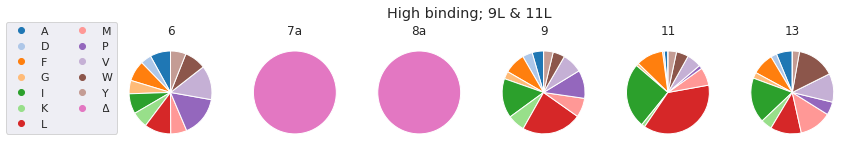

In [138]:
restrict = {'7a':['Δ'], '8a':['Δ']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L')

In [25]:

    # enrich9, enrich11 = single_position_enrichment(all_ref, 'mek', 'high', 10, True)

    # export_covariation_csv(all_ref, 'mek', 'high', 10)
    # point = single_position_enrichment(all_ref, 'mek', 'high', 10)
    # covar = position_covariation(all_ref, 'mek', 'high', 10)
    # point_Shannon = {}
    # for pos in point.keys():
    #     point_Shannon[pos] = position_entropy(point, pos)
    # pprint.pprint(point_Shannon)
    #
    # joint_MI_normalized = {}
    # for pos_a in point.keys():
    #     joint_MI_normalized[pos_a] = {}
    #     for pos_b in point.keys():
    #         joint_MI_normalized[pos_a][pos_b] = mutual_information(point, covar, pos_a, pos_b)
    #
    # pprint.pprint(joint_MI_normalized)

    # top_variant_distribution('mek', 'low', 'low_enrichment.csv', cutoff=10)
    # top_variant_distribution(mek, 'high', 'Top hits - High.csv')
    # top_variant_distribution(mek, 'med', 'Top hits - Med.csv')
    # top_variant_distribution(mek, 'low', 'Top hits - Low.csv')
    # top_variant_distribution(mek, 'low-v2', 'Top hits - Low-v2.csv')

    # export_top_variants('mek', 'low', 'MEK_above_5_Low.csv', cutoff=5)
    # export_top_variants('mek', 'low-v2', 'MEK_above_20_Low-v2.csv', cutoff=20)
    # export_top_variants('mek', 'med', 'MEK_above_10_Medium.csv', cutoff=10)
    # export_top_variants('mek', 'high', 'MEK_above_100_High.csv', cutoff=100)

    # aln_file = protein_needle('FRET tested.fasta', args.reference)
    #retrieve_ind_clones(mek, 'FRET tested.aln', 'FRET_counts.csv')

NameError: name 'retrieve_ind_clones' is not defined